In [35]:
import numpy as np
from PIL import Image
import cv2
from matplotlib import pyplot as plt

Imagen como arreglo

In [36]:
stego_array = np.array(Image.open('riddle.png'))

Se analiza cómo se distribuyen los valores en cada canal

In [37]:
canal_rojo = np.bincount(stego_array[..., [0]].flatten())
canal_verde = np.bincount(stego_array[..., [1]].flatten())
canal_azul = np.bincount(stego_array[..., [2]].flatten())

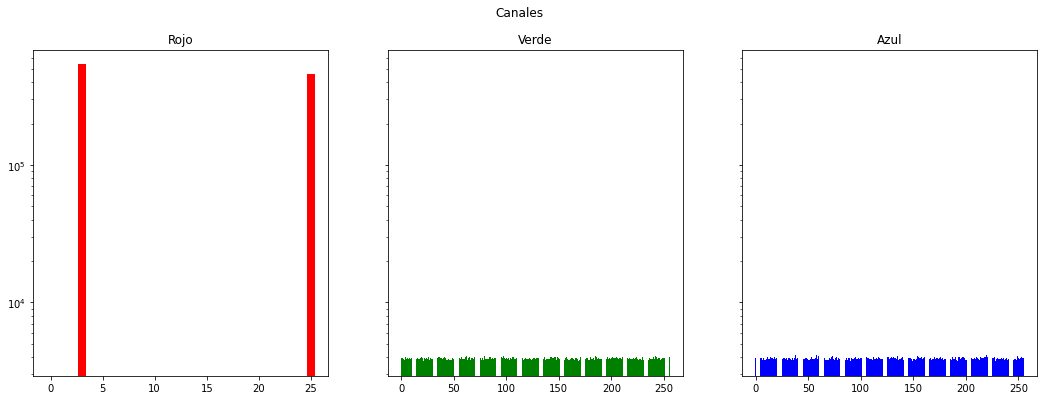

In [38]:
fig, axs = plt.subplots(1, 3, figsize=(18,6), sharey=True)

fig.suptitle('Canales')

axs[0].bar(range(canal_rojo.shape[0]), canal_rojo, color='red')
axs[0].set_title("Rojo")
axs[1].bar(range(canal_verde.shape[0]), canal_verde, color='green')
axs[1].set_title("Verde")
axs[2].bar(range(canal_azul.shape[0]), canal_azul, color='blue')
axs[2].set_title("Azul")

plt.yscale('log')
plt.show()

In [39]:
np.unique(stego_array[..., [0]].flatten())

array([ 3, 25], dtype=uint8)

Los canales G y B contienen valores aleatorios distribuidos uniformemente entre 0 y 255, mientras que R acumula ocurrencias en solo dos de los valores posibles: 3 y 25. Por esto se anulan los primeros y se presenta el resultado.

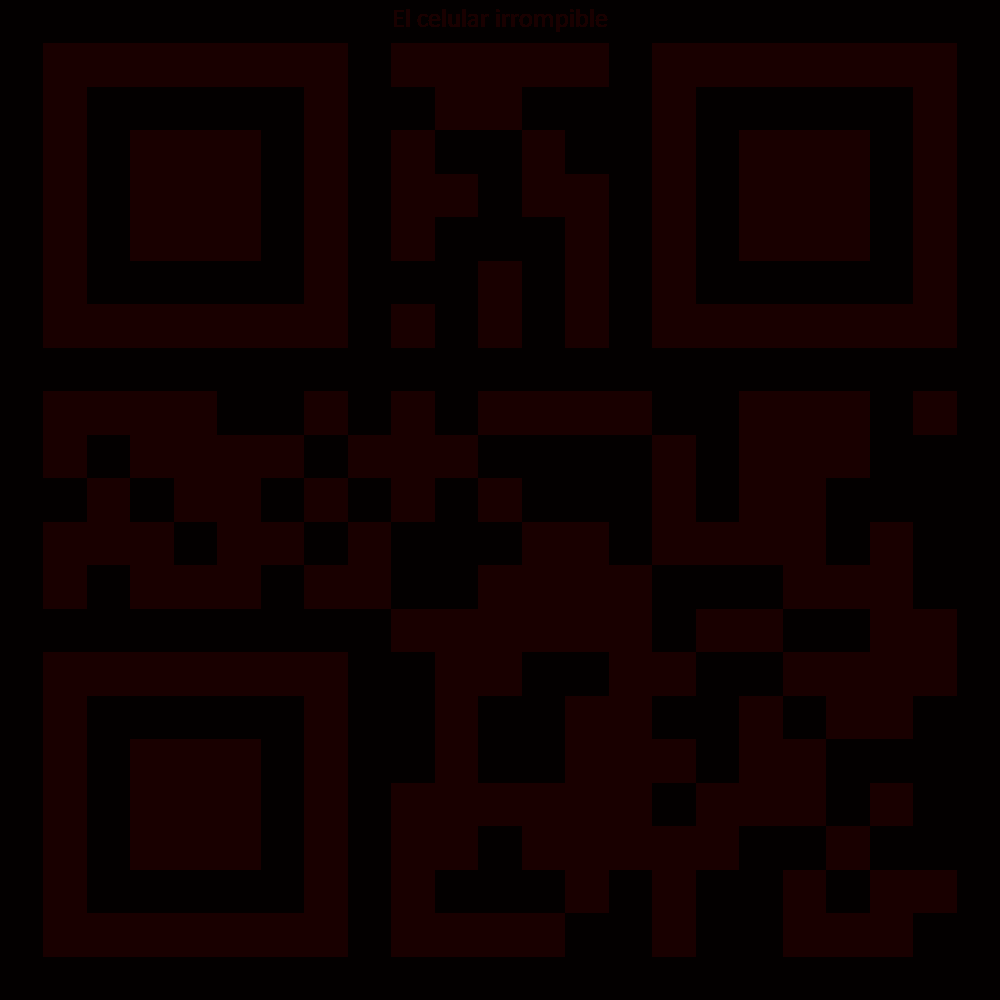

In [40]:
stego_array[..., [1,2 ]] = 0
exposed_secret = Image.fromarray(stego_array)
exposed_secret

El patrón emerge. Se convierte el resultado a una imagen en blanco y negro para poder ser detectada por un lector de código QR.

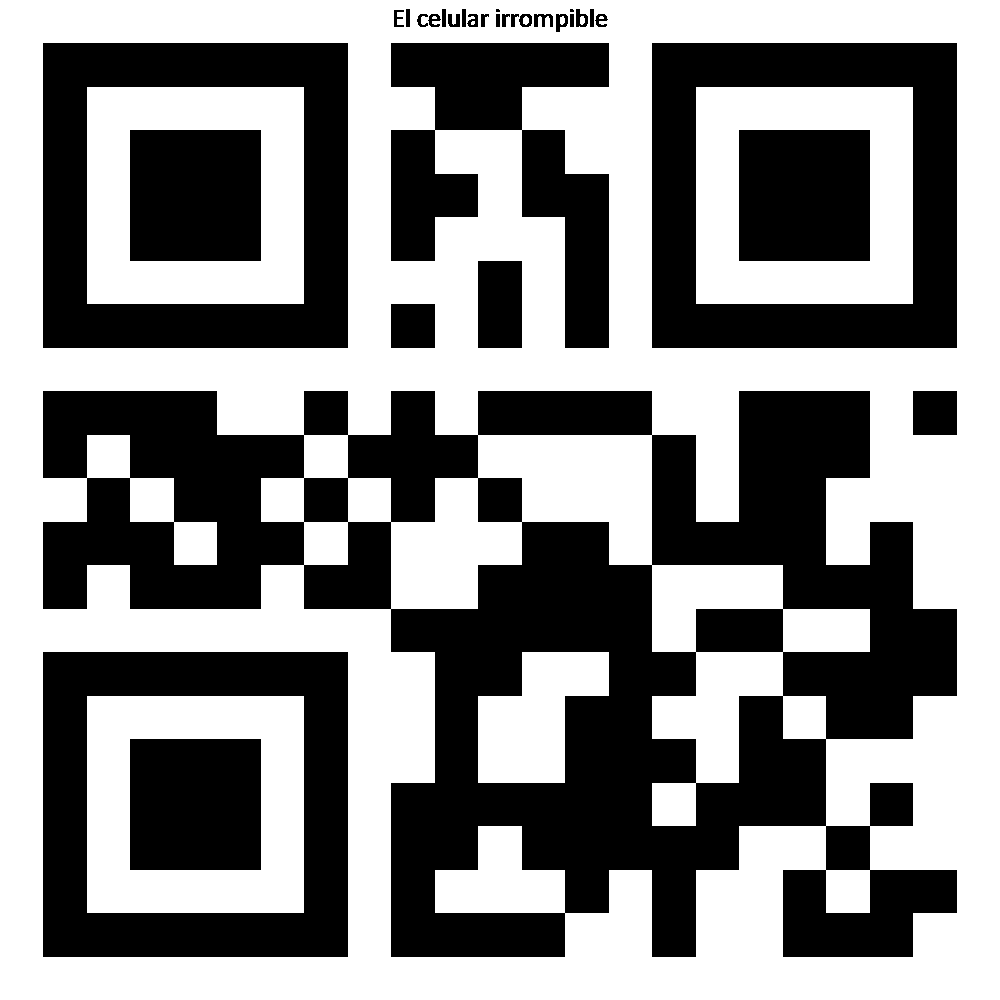

In [41]:
stego_array[(stego_array == np.array([3, 0, 0])).all(axis=-1)] = [255, 255, 255]
stego_array[(stego_array == np.array([25, 0, 0])).all(axis=-1)] = [0, 0, 0]

exposed_secret = Image.fromarray(stego_array)
exposed_secret

In [42]:
detector = cv2.QRCodeDetector()
data, _, _ = detector.detectAndDecode(np.array(exposed_secret))
data

'32827777222444336622233288777787772555'

In [40]:
get_text_by_sms(data)

'datascienceaustral'

# hasta aca

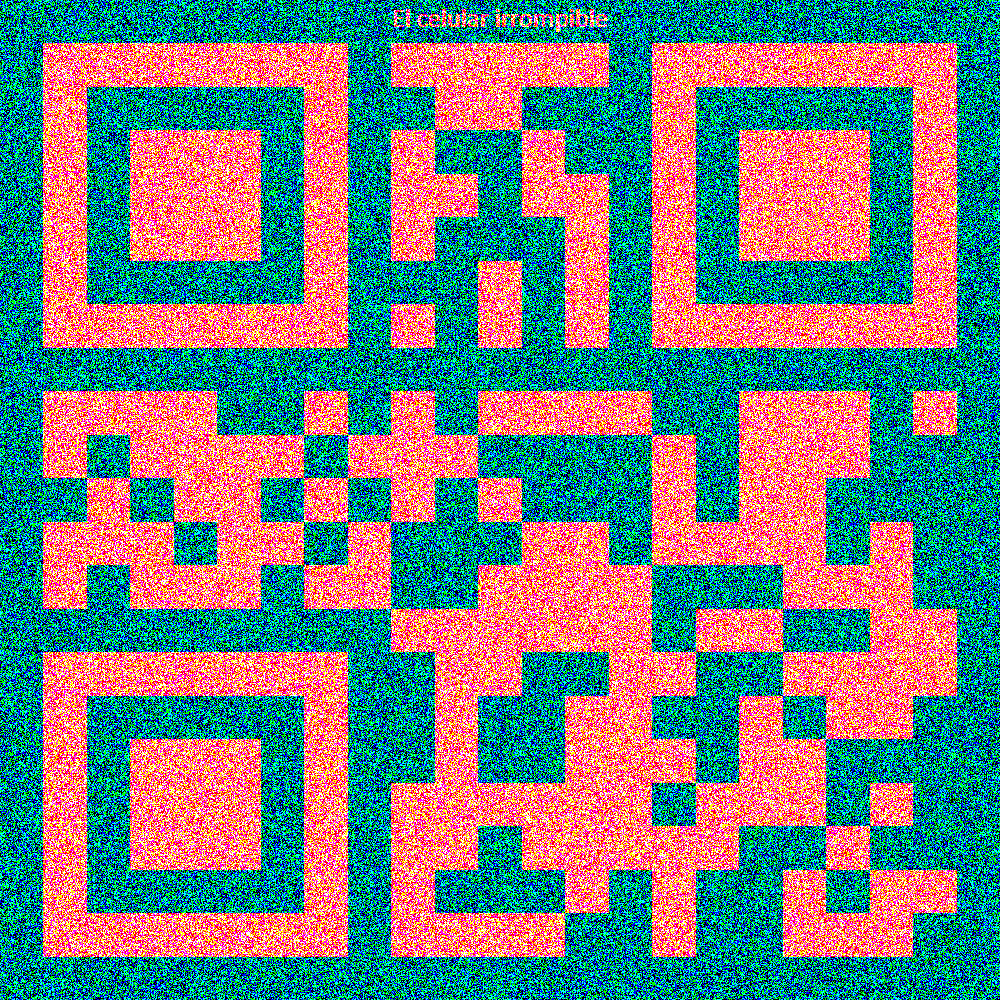

In [31]:
# https://medium.com/@stephanie.werli/image-steganography-with-python-83381475da57

from PIL import Image
import numpy as np

secret = Image.open("./riddle.png")
data_s = np.array(secret)

bit = np.bitwise_and(np.right_shift(data_s, 1), 1)
data_s = bit ^ data_s & 1
data_s *= np.uint(255)

Image.fromarray(data_s)

In [15]:
import cv2

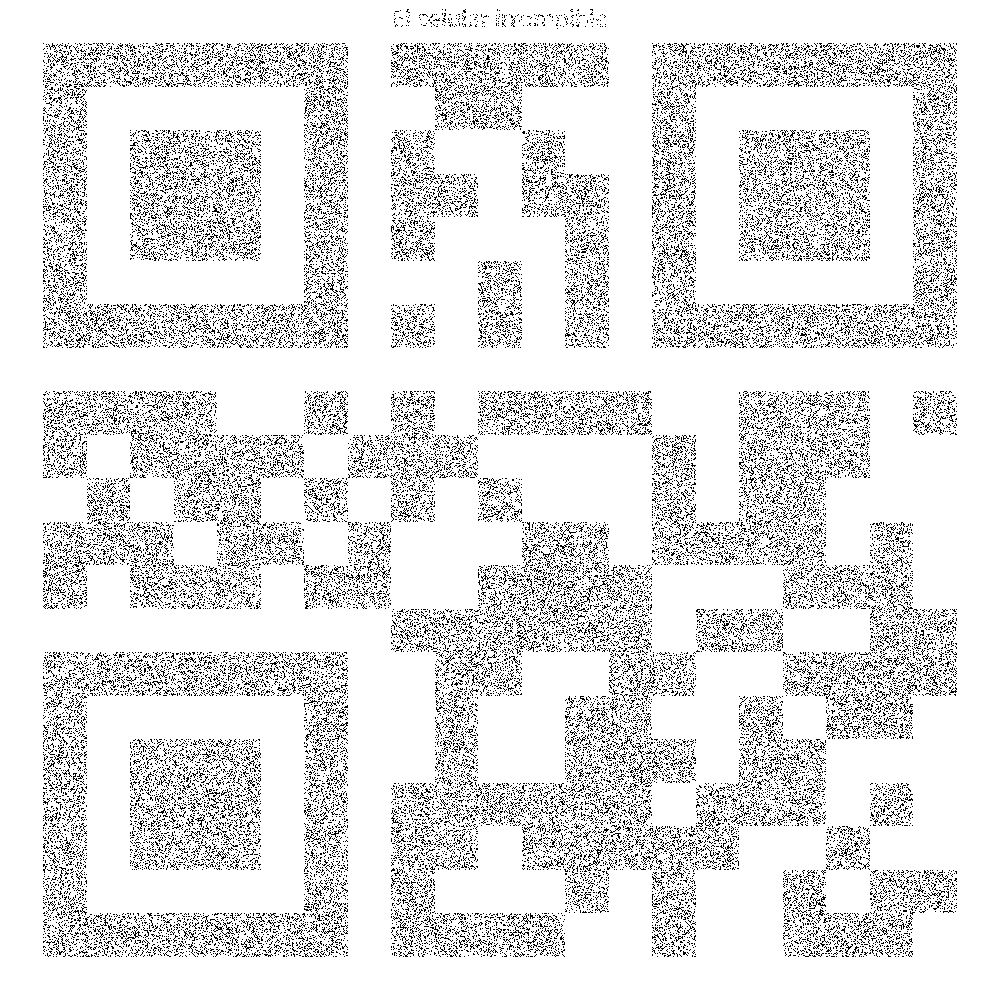

In [81]:
# filtramos la imagen de un color rojo clarito al rojo puro
# y lo invertimos para que quede en formato qr
mask = cv2.inRange(data_s, np.array([50, 0, 0]), np.array([255, 0, 0]))
mask = 255 - mask
Image.fromarray(mask)

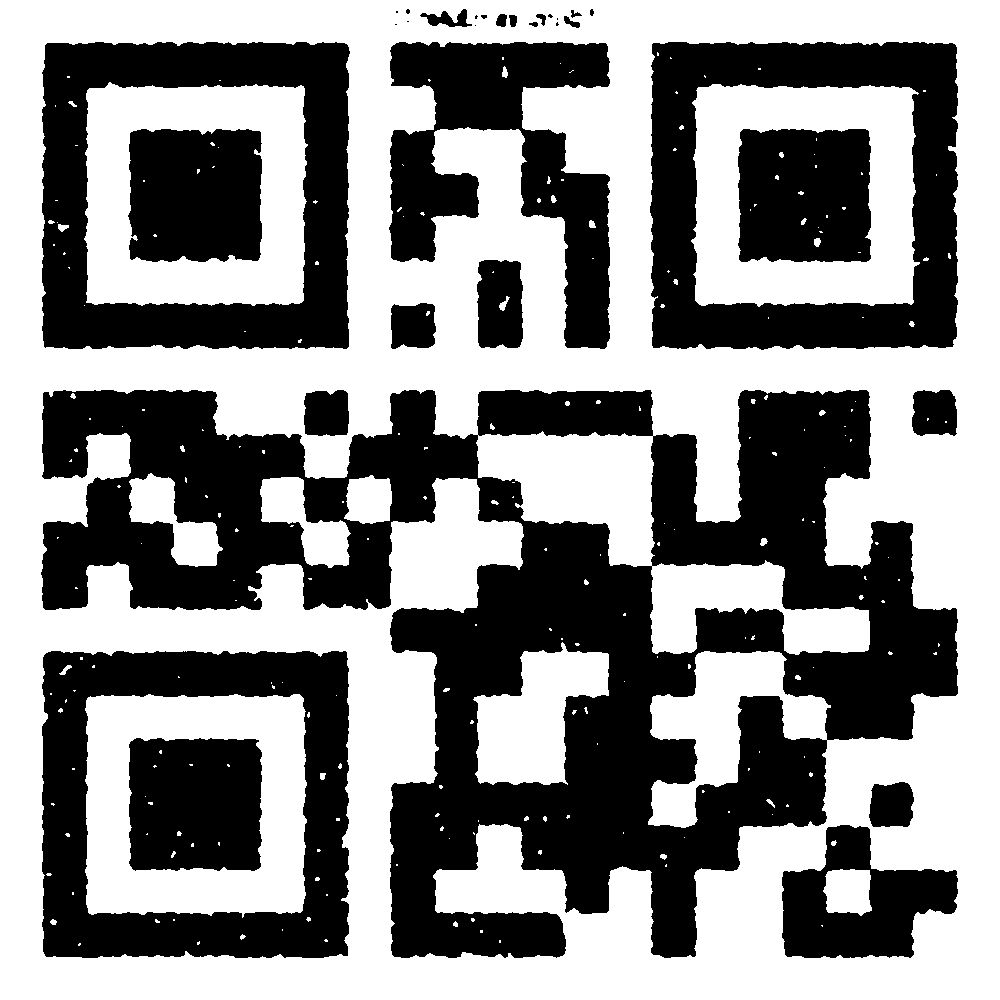

In [83]:
# aplicamos un blur para acentuar el qr
blur = cv2.GaussianBlur(mask, (13, 13), 0)
ret, bw_im = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
Image.fromarray(bw_im)

In [84]:
from pyzbar.pyzbar import decode
from pyzbar.pyzbar import ZBarSymbol

In [85]:
barcodes = decode(bw_im, symbols=[ZBarSymbol.QRCODE])
barcodes

[Decoded(data=b'32827777222444336622233288777787772555', type='QRCODE', rect=Rect(left=43, top=43, width=913, height=914), polygon=[Point(x=43, y=43), Point(x=43, y=957), Point(x=956, y=954), Point(x=956, y=43)], quality=1, orientation='UP')]

In [103]:
barcodes[0].data

b'32827777222444336622233288777787772555'

In [7]:
# teniendo en cuenta que en la imagen decia "el celular irrompible",
# puede ser que estos numeros correspondan a un texto utilizando el
# teclado de los celulares viejos
def get_character(value: str) -> str:
    mapping = {
        '2': ['a', 'b', 'c'],
        '3': ['d', 'e', 'f'],
        '4': ['g', 'h', 'i'],
        '5': ['j', 'k', 'l'],
        '6': ['m', 'n', 'o'],
        '7': ['p', 'q', 'r', 's'],
        '8': ['t', 'u', 'v'],
        '9': ['w', 'x', 'y', 'z'],
    }
    possible_chars = mapping[value[0]]
    return possible_chars[len(value) - 1]

In [8]:
get_character('44') + get_character('666') + get_character('555') + get_character('2')

'hola'

In [9]:
def get_text_by_sms(sms: str) -> str:
    # Agregamos un ultimo caracter dummy
    sms += '.'
    
    prev_char = sms[0]
    buffer = prev_char
    text = ''
    for current_char in sms[1:]:
        if current_char == prev_char:
            buffer += current_char
        else:
            text += get_character(buffer)
            buffer = current_char
            prev_char = current_char
    return text


In [100]:
get_text_by_sms('446665552')

'hola'

In [104]:
get_text_by_sms(barcodes[0].data.decode("utf-8"))

'datascienceaustral'